In [1]:
import numpy as np 
import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
import math
from os import listdir
from skimage import novice
from scipy.misc import imshow
from scipy.ndimage import rotate
import scipy
from os import mkdir

In [2]:
d_images = list()
u_images = list()
p_images = list()
for image in listdir('full_dataset/d'):
    d_images.append('full_dataset/d/'+image)
for image in listdir('full_dataset/u'):
    u_images.append('full_dataset/u/'+image)
for image in listdir('full_dataset/p'):
    p_images.append('full_dataset/p/'+image)
data = np.ndarray([1986,96*96*3])
i = 0
for image in d_images:
    raw = novice.open(image)
    raw.size = (96,96)
    data[i] = raw.rgb.reshape([96*96*3])
    i = i+1
for image in u_images:
    raw = novice.open(image)
    raw.size = (96,96)
    data[i] = raw.rgb.reshape([96*96*3])
    i = i+1
for image in p_images:
    raw = novice.open(image)
    raw.size = (96,96)
    data[i] = raw.rgb.reshape([96*96*3])
    i = i+1
data = np.hstack([data, np.zeros([1986,1])])
for i in range(1372,1774):
    data[i][27648]=1
for i in range(1774,1986):
    data[i][27648]=2

np.random.shuffle(data)
train_data = data[0:1500,0:27649]
test_data = data[1500:1986,0:27649]

/usr/lib/python2.7/dist-packages/skimage/util/dtype.py:107: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [3]:
tf.reset_default_graph()

keep_prob = tf.placeholder("float")
x = tf.placeholder(tf.float32, shape=[None, 27648])
y = tf.placeholder(tf.float32, shape=[None, 3])

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

x_image = tf.reshape(x, [-1, 96, 96, 3])
W_conv1 = weight_variable([7, 7, 3, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_conv3 = weight_variable([5, 5, 64, 128])
b_conv3 = bias_variable([128])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

W_conv3 = weight_variable([5, 5, 64, 128])
b_conv3 = bias_variable([128])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

h_pool3_flat = tf.reshape(h_pool3, [-1, 12*12*128])
W_fc1 = weight_variable([12 * 12 * 128, 512])
b_fc1 = bias_variable([512])

h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

W_fc2 = weight_variable([512, 512])
b_fc2 = bias_variable([512])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)

keep_prob = tf.placeholder(tf.float32)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

W_fc3 = weight_variable([512, 3])
b_fc3 = bias_variable([3])

y_conv = tf.matmul(h_fc2_drop, W_fc3) + b_fc3

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_conv))

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

test_images=test_data[0:486,0:27648]
test_labels=np.zeros((486,3))
test_labels[np.arange(486), np.reshape(test_data[0:486,27648:27649].astype(int),[486])]=1

paths=list()
for l in listdir('activations'):
    for img in listdir('activations/'+l):
        paths.append('./activations/'+l+'/'+img)

In [4]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,27648],order='F'),keep_prob:1.0})
    plotNNFilter(units)
def plotNNFilter(units):
    print(units.shape[3])
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(rotate(units[0,:,:,i],90))
def saveActivations(layer,stimuli,path):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,27648],order='F'),keep_prob:1.0})
    filters = units.shape[3]
    for i in range(filters):
        scipy.misc.imsave(path+'/filter_'+str(i+1)+'.jpg', rotate(units[0,:,:,i],90))

In [5]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for j in range(100):
    np.random.shuffle(train_data)
    train_images=train_data[0:1500,0:27648]
    train_labels=np.zeros((1500,3))
    train_labels[np.arange(1500), np.reshape(train_data[0:1500,27648:27649].astype(int),[1500])]=1
    print 'Epoch '+str(j)
    for i in range(30):
        sess.run(train_step, feed_dict={x: train_images[(i*50):(i*50)+50,0:], y: train_labels[(i*50):(i*50)+50,0:], keep_prob: 1.0})
        if (i+1) % 10 == 0:
            trainAccuracy = sess.run(accuracy, feed_dict={x: train_images[(i*50):(i*50)+50,0:], y: train_labels[(i*50):(i*50)+50,0:], keep_prob: 1.0})
            print("step %d, training accuracy %g"%(i+1, trainAccuracy))
    print('%d epoch test accuracy %g' % (j,sess.run(accuracy,feed_dict={x: test_images, y: test_labels, keep_prob: 1.0})))
    if (j+1)%5==0:
        for path in paths:
            ip = novice.open(path+'/input.jpg')
            ip.size = (96,96)
            image = np.reshape(ip.rgb,[1,27648])
            mkdir(path+'/cycle_'+str(j+1))
            mkdir(path+'/cycle_'+str(j+1)+'/layer_1')
            mkdir(path+'/cycle_'+str(j+1)+'/layer_2')
            mkdir(path+'/cycle_'+str(j+1)+'/layer_3')
            saveActivations(h_conv1,image,path+'/cycle_'+str(j+1)+'/layer_1')
            saveActivations(h_conv2,image,path+'/cycle_'+str(j+1)+'/layer_2')
            saveActivations(h_conv3,image,path+'/cycle_'+str(j+1)+'/layer_3')

Epoch 0
step 10, training accuracy 0.64
step 20, training accuracy 0.82
step 30, training accuracy 0.78
0 epoch test accuracy 0.786008
Epoch 1
step 10, training accuracy 0.86
step 20, training accuracy 0.98
step 30, training accuracy 0.92
1 epoch test accuracy 0.839506
Epoch 2
step 10, training accuracy 0.9
step 20, training accuracy 0.88
step 30, training accuracy 0.94
2 epoch test accuracy 0.837449
Epoch 3
step 10, training accuracy 0.98
step 20, training accuracy 0.94
step 30, training accuracy 1
3 epoch test accuracy 0.860082
Epoch 4
step 10, training accuracy 0.94
step 20, training accuracy 0.92
step 30, training accuracy 0.94
4 epoch test accuracy 0.816872
Epoch 5
step 10, training accuracy 0.86
step 20, training accuracy 0.96
step 30, training accuracy 0.94
5 epoch test accuracy 0.839506
Epoch 6
step 10, training accuracy 0.98
step 20, training accuracy 0.96
step 30, training accuracy 0.96
6 epoch test accuracy 0.868313
Epoch 7
step 10, training accuracy 1
step 20, training accu

step 20, training accuracy 1
step 30, training accuracy 1
63 epoch test accuracy 0.90535
Epoch 64
step 10, training accuracy 1
step 20, training accuracy 1
step 30, training accuracy 1
64 epoch test accuracy 0.90535
Epoch 65
step 10, training accuracy 1
step 20, training accuracy 1
step 30, training accuracy 1
65 epoch test accuracy 0.90535
Epoch 66
step 10, training accuracy 1
step 20, training accuracy 1
step 30, training accuracy 1
66 epoch test accuracy 0.90535
Epoch 67
step 10, training accuracy 1
step 20, training accuracy 1
step 30, training accuracy 1
67 epoch test accuracy 0.90535
Epoch 68
step 10, training accuracy 1
step 20, training accuracy 1
step 30, training accuracy 1
68 epoch test accuracy 0.90535
Epoch 69
step 10, training accuracy 1
step 20, training accuracy 1
step 30, training accuracy 1
69 epoch test accuracy 0.90535
Epoch 70
step 10, training accuracy 1
step 20, training accuracy 1
step 30, training accuracy 1
70 epoch test accuracy 0.90535
Epoch 71
step 10, trai

In [6]:
testAccuracy = sess.run(accuracy, feed_dict={x: test_images, y: test_labels, keep_prob:1.0})
print("final test accuracy %g"%(testAccuracy))

final test accuracy 0.90535


correct label :  disguised
predicted label :  disguised


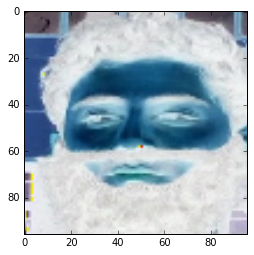

In [7]:
index = 105
imageToUse = test_images[index]
y_correct = test_labels[index]
plt.imshow(rotate(np.reshape(imageToUse,[96,96,3]),90))
y_predict = sess.run(y_conv,feed_dict={x:np.reshape(imageToUse,[1,27648],order='F'),keep_prob:1.0})[0]
max_p=0
max_c=0
for i in range(1,3):
    if y_predict[max_p]<y_predict[i]:
        max_p=i
    if y_correct[max_c]<y_correct[i]:
        max_c=i
labels={0:"disguised", 1:"undisguised", 2:"partially disguised"}
print "correct label : ", labels[max_c]
print "predicted label : ", labels[max_p]

32


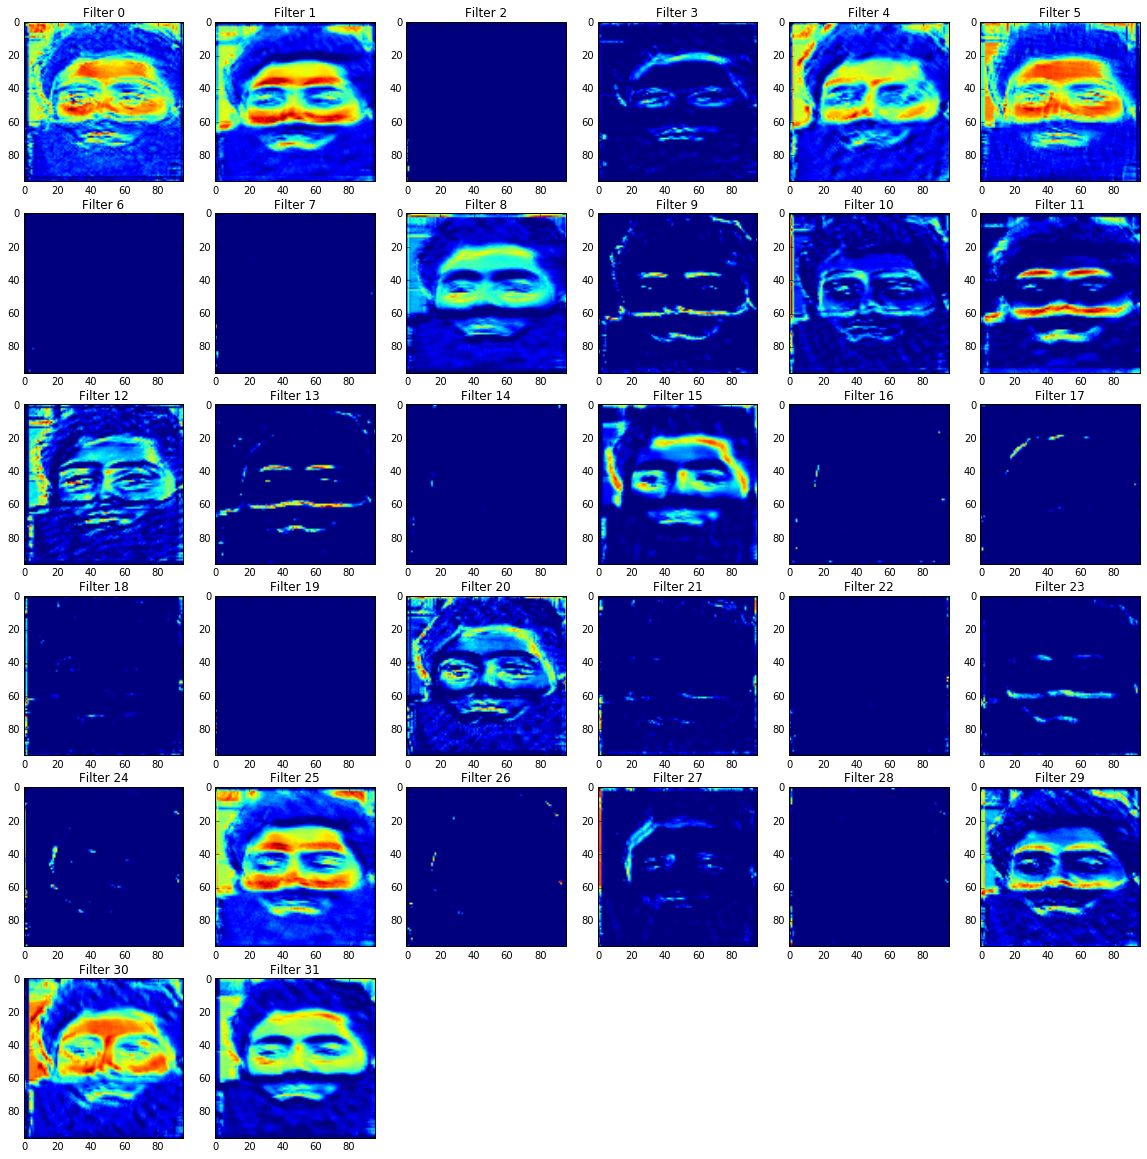

In [8]:
getActivations(h_conv1,imageToUse)

64


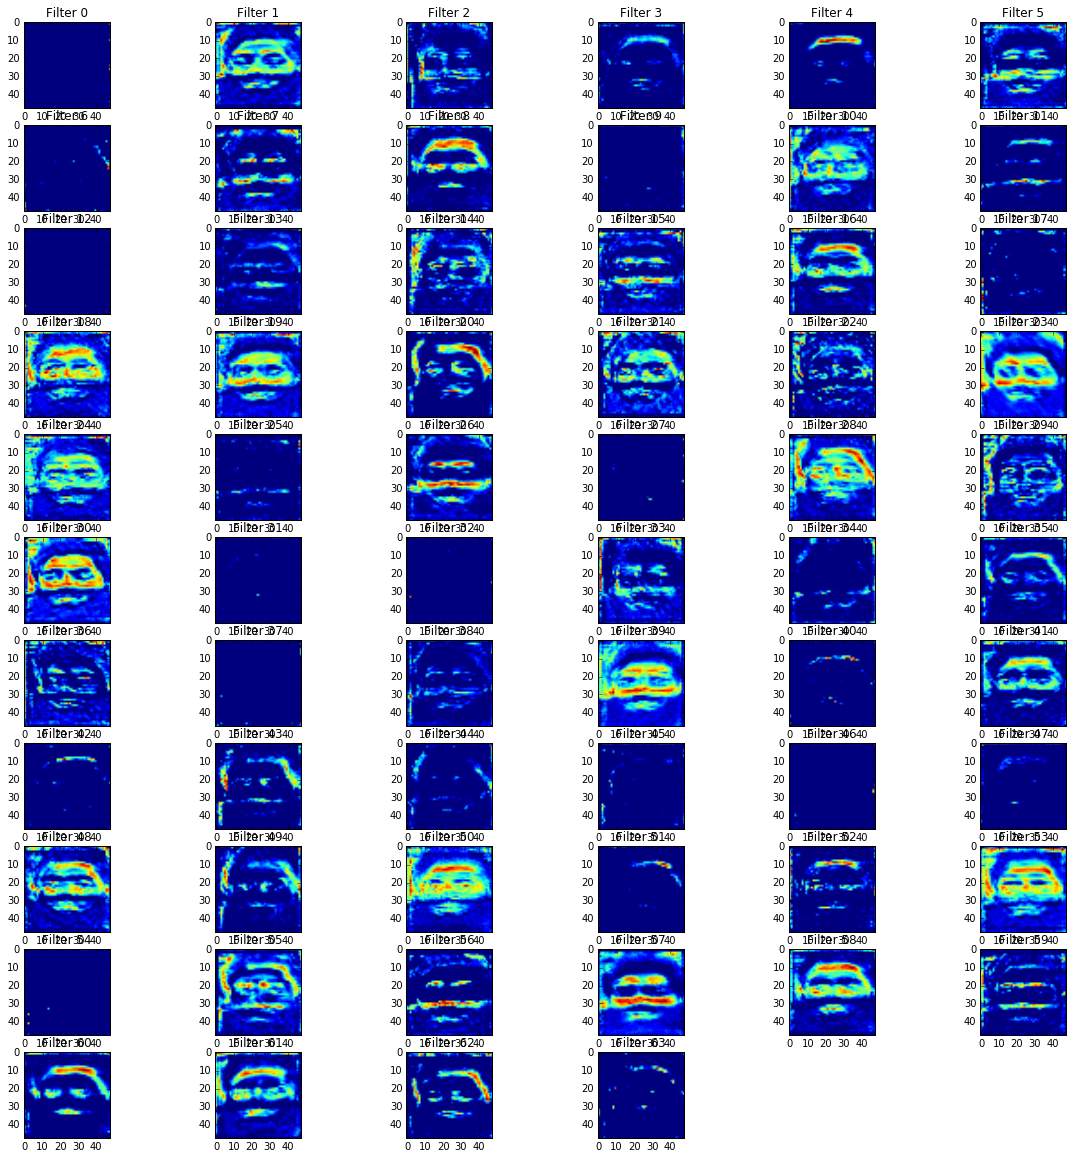

In [9]:
getActivations(h_conv2,imageToUse)

128


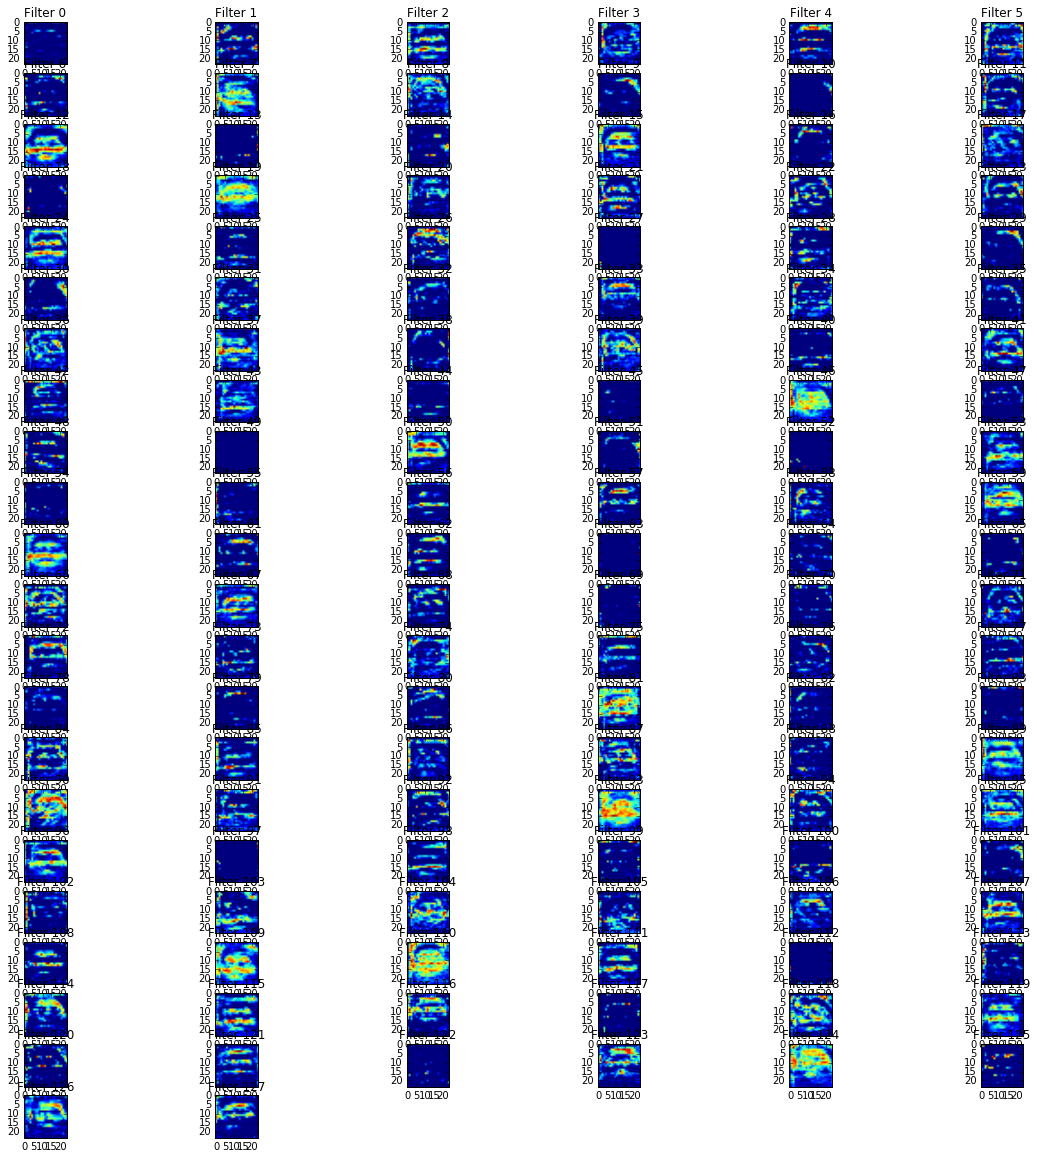

In [10]:
getActivations(h_conv3,imageToUse)